# Pregunta 3

#### a) En primer lugar se genera la matriz dispersa leyendo el archivo de skill de los usuarios.

In [30]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.cross_validation import train_test_split

%matplotlib inline

def CrearSparse():
    row, col, data, linea = [], [], [], []
    lineas = open("user_skill").readlines();
    N = len(lineas)
    D = len(open("skill_id").readlines());
    for n in lineas:
        linea = n.split(":")
        user=int(linea[0])
        features = linea[1].split("\n")[0].split(",")
        features = map(int, features)
        for i in features:
            row.append(user)
            col.append(i)
            data.append(1)
    
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    Z = csr_matrix((data, (row, col)), shape=(N, D))
    return Z
        
Z = CrearSparse()


#### b) Se generan las matrices de entrenamiento y de prueba, para ello se utiliza la función "train_test_split" de sklearn que divide aleatoriamente los datos según la semilla que se le pase como parámetro.

In [37]:
Z_tr, Z_ts = train_test_split(Z, test_size=0.25, random_state=0)
Z_ts.shape

(1973, 14544)

In [32]:
competencias = Z.sum(axis=0)

#### c)  Se crea un gráfico para visualizar el número de usuarios que declara cada competencia. Debido a que son muchas competencias y además están en distintos órdenes de magnitud, se opta por un gráfico logarítmico.

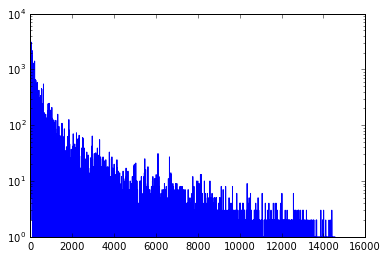

In [33]:
plt.semilogy(competencias.A1)

#### d) Se escoge en este caso la séptima columna que corresponde a PHP para ser evaluada y estimada por los clasificadores.

In [34]:
y_tr = Z_tr.getcol(6).A.T[0]
# notar como se escoge indice print y_tr[25,0]
X_tr = hstack([Z_tr[:,0:6],Z_tr[:,6+1:]]).tocsr()
y_ts = Z_ts.getcol(6).A.T[0]
X_ts = hstack([Z_ts[:,0:6],Z_ts[:,6+1:]]).tocsr()

#### e)  A continuación se definen los clasificadores a utilizar, que corresponden a Bernoulli, Multinomial NB, regresión logística, SVM y KNN.

In [35]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt,yt)
    print "Training Accuracy %s: %f"%(text,acc_tr)
    print "Test Accuracy %s: %f"%(text,acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))
    
def do_NAIVE_BAYES(x,y,xt,yt):
    model = BernoulliNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"BernoulliNB")
    return model

def do_MULTINOMIAL(x,y,xt,yt):
    model = MultinomialNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"MULTINOMIAL")
    return model

def do_LOGIT(x,y,xt,yt):
    model = LogisticRegression(penalty='l2')
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"LOGISTIC")
    
def do_SVM(x,y,xt,yt):
    model = LinearSVC()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"SVM")

def do_KNN(x,y,xt,yt):
    model = KNeighborsClassifier()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"K-NN")

In [36]:
do_KNN(X_tr, y_tr, X_ts, y_ts)
print '----------------------------------------------------------'
do_NAIVE_BAYES(X_tr, y_tr, X_ts, y_ts)
print '----------------------------------------------------------'
do_MULTINOMIAL(X_tr, y_tr, X_ts, y_ts)
print '----------------------------------------------------------'
do_LOGIT(X_tr, y_tr, X_ts, y_ts)
print '----------------------------------------------------------'
do_SVM(X_tr, y_tr, X_ts, y_ts)


Training Accuracy K-NN: 0.918540
Test Accuracy K-NN: 0.915357
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.92      0.99      0.95      1718
          -       0.87      0.40      0.55       255

avg / total       0.91      0.92      0.90      1973

----------------------------------------------------------
Training Accuracy BernoulliNB: 0.914315
Test Accuracy BernoulliNB: 0.901673
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.95      0.94      0.94      1718
          -       0.62      0.63      0.62       255

avg / total       0.90      0.90      0.90      1973

----------------------------------------------------------
Training Accuracy MULTINOMIAL: 0.906878
Test Accuracy MULTINOMIAL: 0.881399
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.97      0.89      0.93      1718
          -      

Como se aprecia en las tablas, el mejor resultado se obtiene mediante regresión logística y SVM, sin embargo estas dos técnicas tienden a sobre ajustar, debido a que se requieren un ajuste de hiperparametros, ya que al ser un espacio de dimensiones tan grande(14544) los hiperplanos que forman separan casi perfectamente el espacio de características en los datos de entrenamiento formando así "hard margin". Aun así, siguen siendo técnicas efectivas debido a la naturaleza y simplicidad. Los métodos Naive Bayes generalizan de buena manera y obtienen resultados levemente peores que RL y SVM. 

Finalmente KNN es uno de los métodos para clasificación más simples, y que en este caso funciona muy bien, a pesar que KNN en un espacio de alta dimensionalidad puede tener un gran error, ya que los puntos que representan los datos están muy dispersos en el espacio, la tarea de agrupar vecinos basado en su cercanía se torna compleja, y si los datos no están muy compactados, se pierde la noción de clases. Afortunadamente este no es el caso, y KNN presenta buenos resultados en términos de complejidad y eficacia.

La cantidad de datos es mucho menor que el número de características, por ello la densidad que ocupan los datos en el espacio es muy pequeña, esto muestra cómo afecta la maldición de la dimensionalidad a los algoritmos de clasificación, particularmente a los que se basan en medidas de longitud como la distancia euclidiana al lidiar con problemas de esta naturaleza.